Notebook to detect a new image file in a  folder, run the inference engine, display and annotate the image

Object detection code is based on https://blog.roboflow.com/training-a-tensorflow-faster-r-cnn-object-detection-model-on-your-own-dataset/ 

V1 - identifies a new incoming rgb image from camera,  scales it to 416x312 and grayscales the image before running the inference graph on it



In [1]:
pip list

Package                       Version
----------------------------- -------------------
absl-py                       1.0.0
apache-beam                   2.39.0
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
asttokens                     2.0.5
astunparse                    1.6.3
Note: you may need to restart the kernel to use updated packages.attrs                         21.4.0
avro-python3                  1.10.2
backcall                      0.2.0
beautifulsoup4                4.11.1
bleach                        4.1.0
Bottleneck                    1.3.4
cachetools                    5.2.0

certifi                       2022.6.15
cffi                          1.15.0
charset-normalizer            2.0.12
cloudpickle                   2.1.0
colorama                      0.4.4
contextlib2                   21.6.0
crcmod                        1.7
cycler                        0.11.0
Cython                        0.29.30
debugpy                       1.5.1
deco

In [49]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

In [50]:
import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile

import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

PATH_TO_LABELS='UK-pollen-plus-Lycopodium_label_map.pbtxt'
PATH_TO_CKPT='frozen_inference_graph.pb'

Modified load_image_into_numpy_array to deal with grayscale images

In [51]:
def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.stack((np.array(image.getdata()),)*3, axis=-1).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

In [52]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=90, use_display_name=True)
category_index = label_map_util.create_category_index(categories)




# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            print ("running inference for image")
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

In [60]:
# Output images not showing? Run this cell again, and try the cell above
# This is needed to display the images.
%matplotlib notebook

Need to detect an incoming image file from the camera - using watchdog

Based on example code at https://thepythoncorner.com/posts/2019-01-13-how-to-create-a-watchdog-in-python-to-look-for-filesystem-changes/

In [54]:
import time
import os
from watchdog.observers import Observer
from watchdog.events import PatternMatchingEventHandler

In [55]:
if __name__ == "__main__":
    patterns = ["*"]
    ignore_patterns = None
    ignore_directories = False
    case_sensitive = True
    my_event_handler = PatternMatchingEventHandler(patterns, ignore_patterns, ignore_directories, case_sensitive)


In [61]:
def on_created(event):
#def on_created(event):
    time.sleep(2)
   
    print(f"File: {event.src_path} has been created")
#check its an image file
    image = Image.open(event.src_path)
    
#required image size
    size=(416,312)
    
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it. Image is converted to grayscale and resized to size to 
# match images used to train model and reduce prcoessing

    image_np = load_image_into_numpy_array(image.convert('L').resize(size))
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
# Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)

#run the inference engine to get bounding boxes and labels
#plot the results against the image
#scale the boxes to match the original file        
#put the results somewhere for UI to find them         
def on_deleted(event):
     print(f" File: {event.src_path} was deleted")
def on_modified(event):
     print(f"File: {event.src_path} has been modified")
def on_moved(event):
    print(f"File: {event.src_path} moved to {event.dest_path}")

In [62]:
my_event_handler.on_created = on_created
my_event_handler.on_deleted = on_deleted
my_event_handler.on_modified = on_modified
my_event_handler.on_moved = on_moved


In [63]:
path = "./image-in"
%ls path
go_recursively = True
my_observer = Observer()
my_observer.schedule(my_event_handler, path, recursive=go_recursively)

 Volume in drive C is OS
 Volume Serial Number is 0493-A886

 Directory of C:\Users\drgmh\Documents\University\pollen project\notebooks



File Not Found


<ObservedWatch: path=./image-in, is_recursive=True>

 File: ./image-in\rgb full size.jpg was deleted
File: ./image-in\rgb full size.jpg has been created
running inference for image


<IPython.core.display.Javascript object>


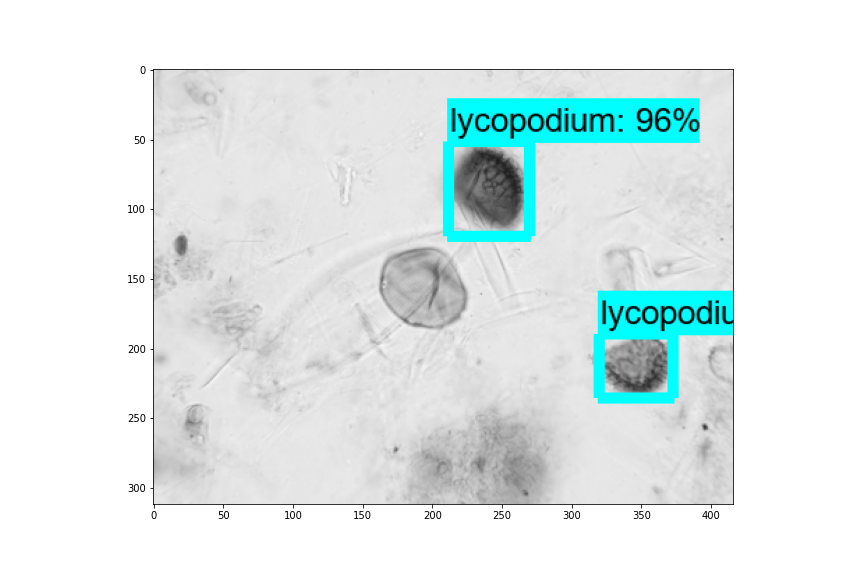

File: ./image-in\rgb full size.jpg has been modified


In [64]:
my_observer.start()
try:
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    my_observer.stop()
    my_observer.join()